In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2
import sample_data

np.random.seed(0)
N_train = 50000; N_test = 0
N = N_train + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train
n_min = 100; n_max = 100

X, y = sample_data.synthetic_control(N, n_min, n_max, even=True, sigma=0.0)

Using TensorFlow backend.


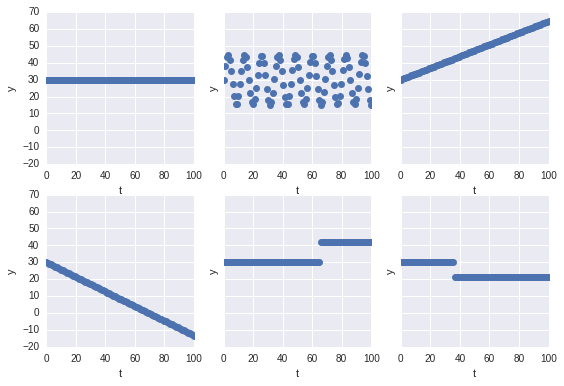

In [2]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
    i = np.where(y == j)[0][0]
#    i = j
    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
#    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")

In [3]:
import os
import tensorflow as tf
from keras import backend as K
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM, Dropout,
                          merge, Reshape, Flatten, RepeatVector,
                          Convolution1D, MaxPooling1D)
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ProgbarLogger, TensorBoard
from IPython.display import clear_output


def classification_lstm(lstm_size, lr):
    sess = tf.Session()#config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.33)))
    K.set_session(sess)
    run = "periodic_lstm{}_{:1.0e}_drop{}".format(lstm_size, lr, drop_frac).replace('e-', 'm').replace('.', '')
    model = Sequential()
    model.add(LSTM(lstm_size, input_shape=(n_max, 1), return_sequences=False))
    model.add(Dropout(drop_frac))
    model.add(Dense(Y.shape[1], activation='softmax'))
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    log_dir = os.path.expanduser('~/Dropbox/Documents/timeflow/keras2_logs/classification/{}'.format(run))
    !rm -rf $log_dir
    history = model.fit(X[train], Y[train], nb_epoch=nb_epoch, verbose=0,
                        batch_size=batch_size, validation_split=0.2,
                        callbacks=[ProgbarLogger(), TensorBoard(log_dir=log_dir, write_graph=False)])
    return (run, history)


def classification_conv_lstm(lstm_size, lr, filter_length, nb_filter, pool_length):
    sess = tf.Session()#config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.33)))
    K.set_session(sess)
    run = "periodic_2conv_lstm{}_flen{}_nf{}_plen{}_{:1.0e}_drop{}".format(lstm_size, filter_length, nb_filter, pool_length, lr, drop_frac).replace('e-', 'm').replace('.', '')
    model = Sequential()
    model.add(Convolution1D(input_shape=(n_max, 1), nb_filter=nb_filter, 
                            filter_length=filter_length,
                            border_mode='valid', activation='relu',
                            subsample_length=1))
    model.add(MaxPooling1D(pool_length=pool_length))
    model.add(Convolution1D(input_shape=(n_max, 1), nb_filter=nb_filter, 
                        filter_length=filter_length,
                        border_mode='valid', activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=pool_length))
    model.add(Dropout(drop_frac))
    model.add(LSTM(lstm_size, input_shape=(n_max, 1), return_sequences=False))
    model.add(Dropout(drop_frac))
    model.add(Dense(Y.shape[1], activation='softmax'))
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    log_dir = os.path.expanduser('~/Dropbox/Documents/timeflow/keras2_logs/classification/{}'.format(run))
    !rm -rf $log_dir
    history = model.fit(X[train], Y[train], nb_epoch=nb_epoch, verbose=0,
                        batch_size=batch_size, validation_split=0.2,
                        callbacks=[#ProgbarLogger(),
                                   TensorBoard(log_dir=log_dir, write_graph=False)])
    return (run, history, model)

In [4]:
from itertools import product
from joblib import Parallel, delayed

# Convolution
filter_length = 5
nb_filter = 16
pool_length = 2
# LSTM
#lstm_size = 32
# Training
#lr = 5e-4
drop_frac = 0.25
batch_size = 1000
nb_epoch = 50

Y = to_categorical(y, 6)

Parallel(n_jobs=8)(delayed(classification_conv_lstm)(lstm_size, lr, filter_length, nb_filter, pool_length)
                   for lstm_size, lr in product([64, 128], [1e-4, 2e-4, 5e-4, 1e-3]))

MaybeEncodingError: Error sending result: '[('periodic_2conv_lstm64_flen5_nf16_plen2_1m04_drop025', <keras.callbacks.History object at 0x7f6a54876be0>)]'. Reason: 'PicklingError("Can't pickle <class 'module'>: attribute lookup module on builtins failed",)'

In [ ]:
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

model_dot = model_to_dot(model).create(prog='dot', format='svg')
SVG(model_dot)